In [4]:
%matplotlib inline

In [5]:
import os 
wd = r'C:\Users\Peter\Desktop\behavioral_analysis'
os.chdir(wd)
os.getcwd()

'C:\\Users\\Peter\\Desktop\\behavioral_analysis'

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import imageio
import itertools
import pickle
import pandas as pd
import seaborn as sns
import anipose_scripts.anipose_main as main
import anipose_scripts.constants as constants
import tools
import pprint
import itertools

plt.rcParams.update({'font.size': 15})

### Load Data

In [7]:
dict_of_data = {x: tools.get_files(main.pose2d_folder, (x + '.h5'))
                for x in constants.CAMERA_NAMES}
pprint.pprint(dict_of_data)

{'CAM0': ['C:\\Users\\Peter\\Desktop\\anipose\\TEST_DATA\\TEST_MOUSE\\TEST_DATE\\ANALYZED\\POSE_2D\\M9_2021.03.08_00000_CAM0.h5',
          'C:\\Users\\Peter\\Desktop\\anipose\\TEST_DATA\\TEST_MOUSE\\TEST_DATE\\ANALYZED\\POSE_2D\\M9_2021.03.08_00001_CAM0.h5',
          'C:\\Users\\Peter\\Desktop\\anipose\\TEST_DATA\\TEST_MOUSE\\TEST_DATE\\ANALYZED\\POSE_2D\\M9_2021.03.08_00002_CAM0.h5',
          'C:\\Users\\Peter\\Desktop\\anipose\\TEST_DATA\\TEST_MOUSE\\TEST_DATE\\ANALYZED\\POSE_2D\\M9_2021.03.08_00003_CAM0.h5',
          'C:\\Users\\Peter\\Desktop\\anipose\\TEST_DATA\\TEST_MOUSE\\TEST_DATE\\ANALYZED\\POSE_2D\\M9_2021.03.08_00004_CAM0.h5',
          'C:\\Users\\Peter\\Desktop\\anipose\\TEST_DATA\\TEST_MOUSE\\TEST_DATE\\ANALYZED\\POSE_2D\\M9_2021.03.08_00005_CAM0.h5',
          'C:\\Users\\Peter\\Desktop\\anipose\\TEST_DATA\\TEST_MOUSE\\TEST_DATE\\ANALYZED\\POSE_2D\\M9_2021.03.08_00006_CAM0.h5',
          'C:\\Users\\Peter\\Desktop\\anipose\\TEST_DATA\\TEST_MOUSE\\TEST_DATE\\ANALYZED\

In [8]:
bps_to_include = np.unique([x for y in main.scheme for x in y])
bp_dict = {bp: i for i, bp in enumerate(bps_to_include)}

In [9]:
video_ix = 0
dfs_per_camera = [pd.read_hdf(dict_of_data[cam][video_ix]) for j, cam in enumerate(constants.CAMERA_NAMES)]
data_per_camera = []
for cam in constants.CAMERA_NAMES:
    file_name = dict_of_data[cam][video_ix]
    df = pd.read_hdf(file_name)
    scorer = df.columns.levels[0][0]
    df = df.loc[:,scorer]

    n_frames = df.shape[0]
    n_joints = len(bps_to_include)
    data = np.array(df[bps_to_include]).reshape(n_frames, n_joints, 3)
    data_per_camera.append(data)
    assert len(df.index) == n_frames
data_all_cameras = np.array(data_per_camera)
data_all_cameras = np.transpose(data_all_cameras, (0, 2, 1, 3))
data_all_cameras.shape # [CAMERA, BODYPARTS, FRAMES, (X, Y, SCORE)]

(2, 10, 1600, 3)

In [10]:
def load_to_np_array(file_name, bps):
    df = pd.read_hdf(file_name)
    scorer = df.columns.levels[0][0]
    df = df.loc[:,scorer]

    n_frames = df.shape[0]
    n_joints = len(bps)
    data = np.array(df[bps]).reshape(n_frames, n_joints, 3)
    return data

### Filtering

1. interpolation:
- the nan gap should not exceed NAN_GAP. i.e. if there is a length of NaNs over the NAN_GAP then there are too many missing values to interpolate

2. segment into discrete chunks:
- for paw, greater than 6/8 points labeled in a given frame counts as a good frame
- for paw, must have greater than 200 ms of contiguous good frames to count as a good chunk

In [11]:
FRAME_RATE = 40
NAN_GAP = 3
SCORE_THRESHOLD = 0.9
SCORE_INTERP = 2
CRITERIA_BP_FRACTION = 0.75
CRITERIA_CONTIGUOUS_SECONDS = .2
DIM_CAMERA = 0
DIM_BP = 1
DIM_FRAME = 2
DIM_COORDS_SCORE = 3
BPS_TRACK_LOCATION = ['r2_in', 'r2_out', 'r3_in', 'r3_out']
BPS_TRACK_PAW =['r1_in', 'r1_out',
                 'r2_in', 'r2_out',
                 'r3_in', 'r3_out',
                 'r4_in', 'r4_out']
BPS_TRACK_PELLET = ['pellet']
BPS_CARE = {'location': BPS_TRACK_LOCATION, 
            'paw': BPS_TRACK_PAW, 
            'pellet': BPS_TRACK_PELLET}


def find_region_bounds(bool_array, min_gap=0, max_gap=0):
    assert(bool_array.dtype == 'bool')
    idx = np.diff(np.r_[0, bool_array, 0]).nonzero()[0]
    regions = np.reshape(idx, (-1, 2))
    if min_gap > 0 and max_gap > 0:
        regions = np.array([r for r in regions if ((r[1] - r[0]) <= max_gap and (r[1]-r[0] >= min_gap))])
    elif min_gap > 0 and max_gap == 0:
        regions = np.array([r for r in regions if (r[1] - r[0]) >= min_gap])
    elif min_gap == 0 and max_gap > 0:
        regions = np.array([r for r in regions if (r[1] - r[0]) <= max_gap])
    else:
        raise ValueError('both min and max gaps are 0')
    region_ixs = np.array(list(itertools.chain(*[range(r[0], r[1]) for r in regions]))).astype(int)
    return regions, region_ixs

def get_interpolated(x, y, score, score_threshold, default_interp_score_val, gap):
    failed_threshold = score < score_threshold
    regions, interp_ixs = find_region_bounds(failed_threshold, max_gap=gap)
    new_x = np.interp(interp_ixs, np.arange(len(x)), x)
    new_y = np.interp(interp_ixs, np.arange(len(y)), y)
    score[interp_ixs] = default_interp_score_val
    x[interp_ixs]=new_x
    y[interp_ixs]=new_y   
    return x, y, score

def get_good_behavioral_chunks(bool_array, gap):
    '''Assumes that 1s in bool_array denotes good frames'''
    regions, region_ixs = find_region_bounds(bool_array, min_gap=gap)
    return regions, region_ixs   
    

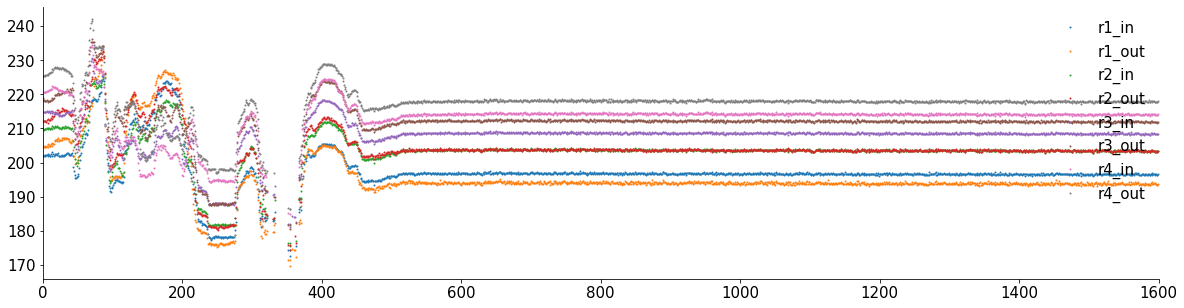

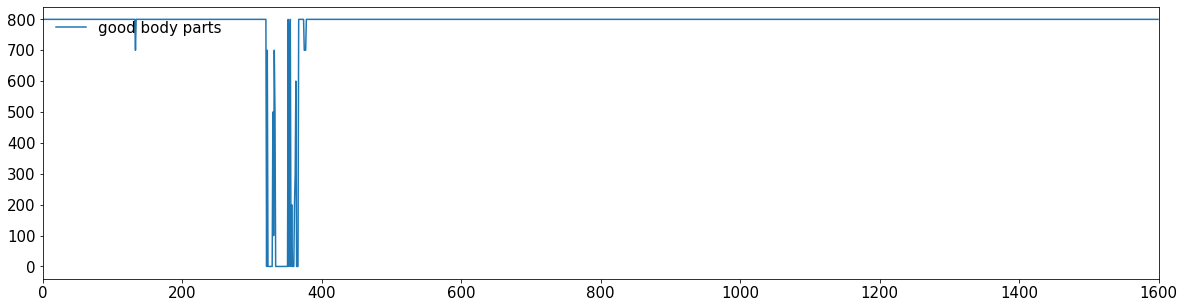

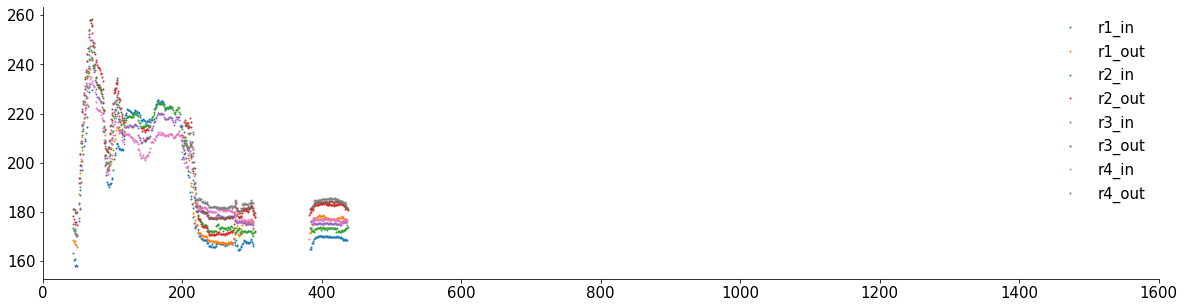

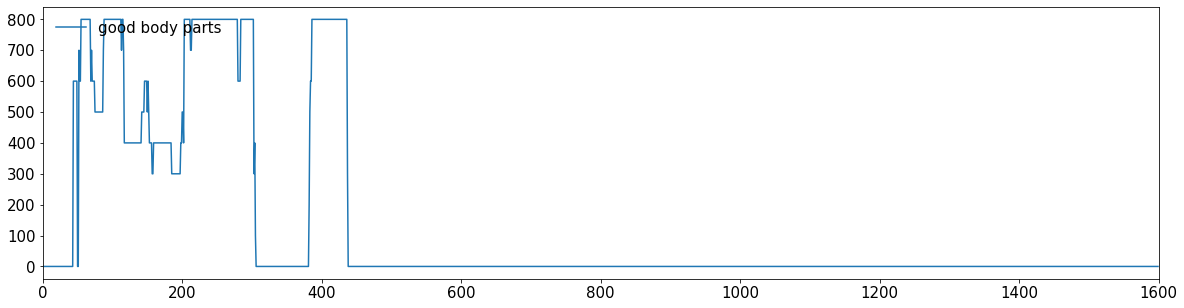

In [12]:
# original
for data_per_camera in data_all_cameras:
    bp_ixs = [bp_dict[bp] for bp in BPS_TRACK_PAW]
    x = data_per_camera[bp_ixs, :, 0]
    y = data_per_camera[bp_ixs, :, 1]
    score = data_per_camera[bp_ixs, :, 2]
    pass_threshold = score > SCORE_THRESHOLD
    num_good_bps = np.sum(pass_threshold, axis=0)
    
    x_ = np.ma.masked_where(score < SCORE_THRESHOLD, x)
    y_ = np.ma.masked_where(score < SCORE_THRESHOLD, y)
    
    plt.figure(figsize=(20, 5))
    mask = data_per_camera[:,]
    plt.plot(x_.T, '.', markersize=2)
    plt.xlim([0, data_per_camera.shape[1]])
    plt.legend(BPS_TRACK_PAW, frameon=False, loc='upper right')
    sns.despine()
    plt.figure(figsize=(20, 5))
    plt.plot(num_good_bps*100)
    plt.xlim([0, data_per_camera.shape[1]])
    plt.legend(['good body parts'], frameon=False, loc='upper left')

In [13]:
# interpolate small missing regions per body part
data_interp = np.copy(data_all_cameras)
for cam, data_per_camera in enumerate(data_interp):
    for ix, bp in enumerate(data_per_camera):
        x, y, score = get_interpolated(x=data_per_camera[ix, :, 0], 
                                        y=data_per_camera[ix, :, 1],
                                        score=data_per_camera[ix, :, 2],
                                        score_threshold=SCORE_THRESHOLD,
                                        default_interp_score_val=SCORE_INTERP,
                                        gap=NAN_GAP)
        data_interp[cam, ix, :, 0] = x
        data_interp[cam, ix, :, 1] = y
        data_interp[cam, ix, :, 2] = score

In [14]:
# chunk into good segments
frame_threshold = np.ceil(CRITERIA_CONTIGUOUS_SECONDS * FRAME_RATE).astype(int)
for cam, data_per_camera in enumerate(data_interp):
    bps_ix = [bp_dict[bp] for bp in BPS_TRACK_LOCATION]
    relevant_scores = data_per_camera[bps_ix,:,2]
    bool_arr = relevant_scores > SCORE_THRESHOLD
    bool_vec = np.all(bool_arr, axis=0)
    regions, region_ixs = get_good_behavioral_chunks(bool_vec, frame_threshold)

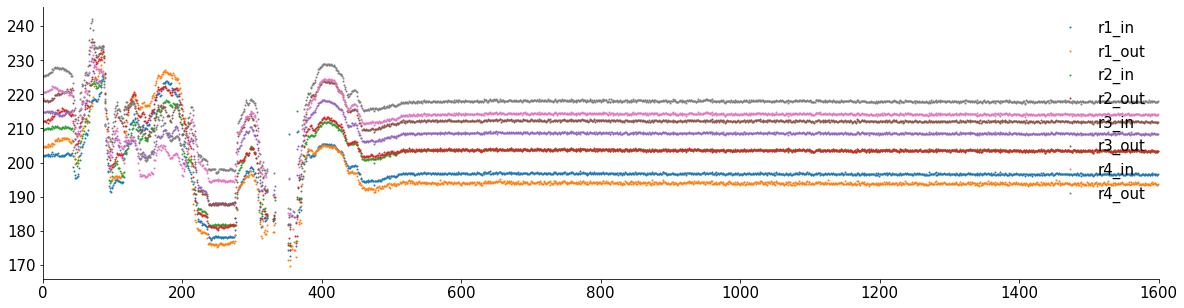

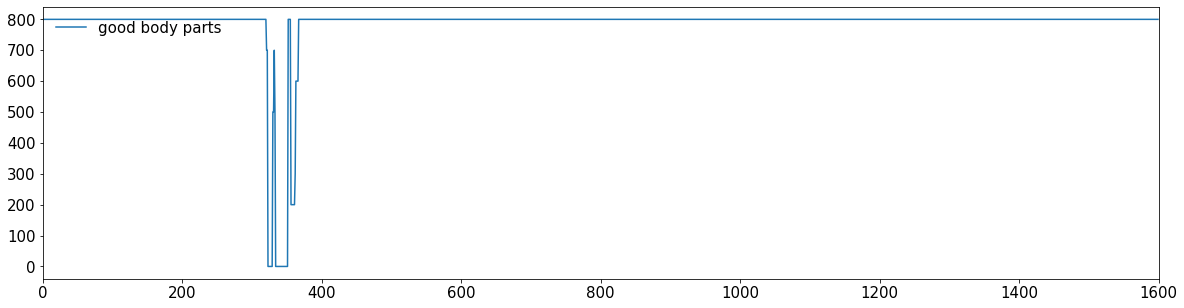

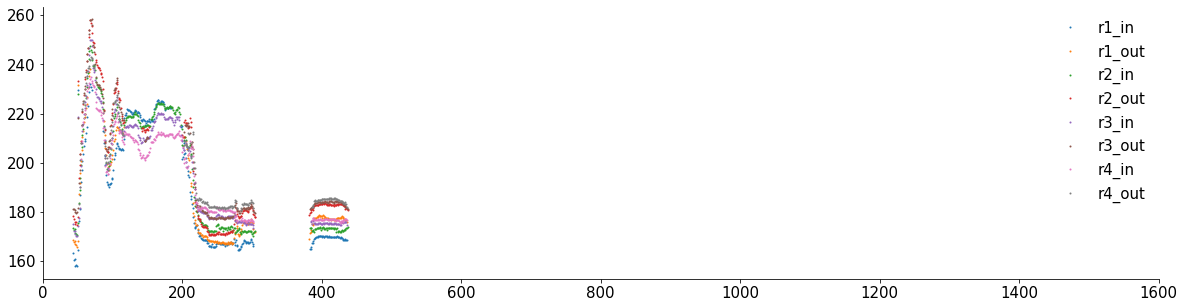

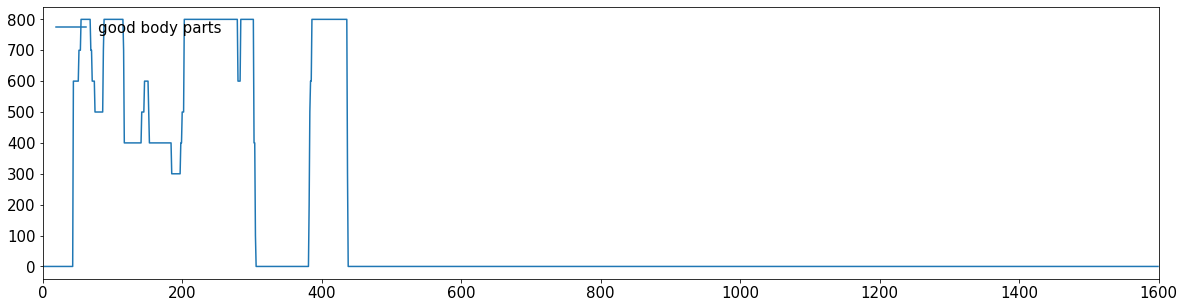

In [16]:
# filtered
score_threshold = 0.9
for data_per_camera in data_interp:
    bp_ixs = [bp_dict[bp] for bp in BPS_TRACK_PAW]
    x = data_per_camera[bp_ixs, :, 0]
    y = data_per_camera[bp_ixs, :, 1]
    score = data_per_camera[bp_ixs, :, 2]
    pass_threshold = score > score_threshold
    num_good_bps = np.sum(pass_threshold, axis=0)
    
    x_ = np.ma.masked_where(score < score_threshold, x)
    y_ = np.ma.masked_where(score < score_threshold, y)
    
    plt.figure(figsize=(20, 5))
    mask = data_per_camera[:,]
    plt.plot(x_.T, '.', markersize=2)
    plt.xlim([0, data_per_camera.shape[1]])
    plt.legend(BPS_TRACK_PAW, frameon=False, loc='upper right')
    sns.despine()
    plt.figure(figsize=(20, 5))
    plt.plot(num_good_bps*100)
    plt.xlim([0, data_per_camera.shape[1]])
    plt.legend(['good body parts'], frameon=False, loc='upper left')